# Lecture : Recommendation on Graphs

## Lab 01 : PageRank

### Xavier Bresson  


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/05_Recommendation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
import scipy.sparse.linalg
import warnings; warnings.filterwarnings("ignore")


# Synthetic small graph

In [3]:
# Data matrix 
mat = scipy.io.loadmat('datasets/pagerank_synthetic.mat')
W = mat['W']
W = scipy.sparse.csr_matrix(W)
Wref = W
X = mat['X']
n = X.shape[0]
d = X.shape[1]
E = mat['E']
XE = mat['X2']
print('num_nodes:',n)


num_nodes: 11


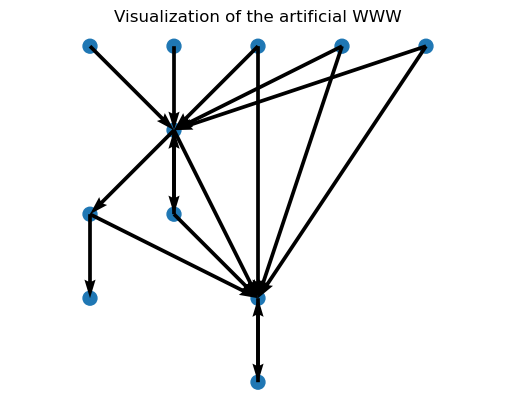

In [4]:
plt.figure(1)
size_vertex_plot = 100
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*np.ones(n))
plt.quiver(XE[:,0], XE[:,1], E[:,0], E[:,1], scale=1., units='xy') 
plt.title('Visualization of the artificial WWW')
plt.axis('equal')
plt.axis('off') 
plt.show()

In [5]:
# Solve eigenproblem

# vector of 1's
e = np.ones([n,1])/n 
one = np.ones([n,1])

# Dumpling vector
D = np.array(W.sum(axis=1),dtype='float32').squeeze()
a_idx = np.zeros([n],dtype='int32')
a_idx[np.where(D<1./2)] = 1
a = (1.0* a_idx)[:,None]

# Compute P = W D^{-1}
invD = 1./(D+1e-10)
invD[a_idx==1] = 0
invD = np.diag(invD)
W = Wref.todense()
P = invD.dot(W).T

# EVD
alpha = 0.85
start = time.time()
Phat = alpha* P +  alpha* e.dot(a.T) + (1.0-alpha)* e.dot(one.T)
Phat = scipy.sparse.csr_matrix(Phat)
lamb, U = scipy.sparse.linalg.eigs(Phat, k=1, which='LM') 
x_pagerank = np.abs(U[:,0])/ np.sum(np.abs(U[:,0]))

# Computational time
print('Computational time for PageRank solution with EIGEN Method (sec):',time.time() - start)

Computational time for PageRank solution with EIGEN Method (sec): 0.0020537376403808594


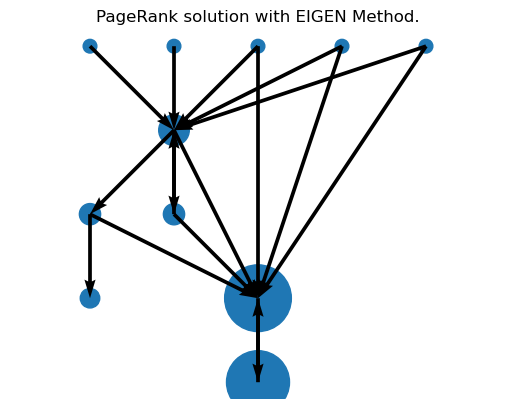

In [6]:
plt.figure(2)
size_vertex_plot = 1e3*6
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*x_pagerank)
plt.quiver(XE[:,0], XE[:,1], E[:,0], E[:,1], scale=1., units='xy') 
plt.title('PageRank solution with EIGEN Method.')
plt.axis('equal')
plt.axis('off') 
plt.show()

In [7]:
# PageRank values
x = x_pagerank
val = np.sort(x)[::-1] 
idx = np.argsort(x)[::-1]
index = np.array(range(1,1+n))
in_degree = np.array(W.sum(axis=0)).squeeze(axis=0)
out_degree =  np.array(W.sum(axis=1)).squeeze(axis=1)
index = index[idx]
in_degree = in_degree[idx]
out_degree = out_degree[idx]
print('\n  ''Node'' | ''PageRank'' | ''In-degree'' | ''Out-degree'' ')
for i in range(n):
    print('   ',index[i], '  ', round(val[i],3) ,'      ', in_degree[i],'      ', out_degree[i], end='\n')


  Node | PageRank | In-degree | Out-degree 
    2    0.384        7.0        1.0
    3    0.343        1.0        1.0
    5    0.081        6.0        3.0
    6    0.039        1.0        2.0
    4    0.039        1.0        2.0
    1    0.033        1.0        0.0
    7    0.016        0.0        2.0
    11    0.016        0.0        1.0
    9    0.016        0.0        2.0
    8    0.016        0.0        2.0
    10    0.016        0.0        1.0


Computational time for PageRank solution with POWER Method (sec): 0.004533052444458008


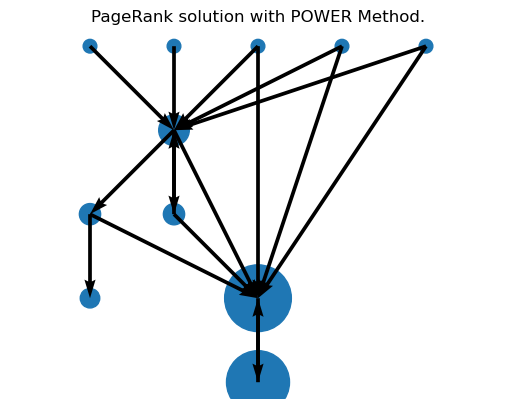

In [8]:
# Power Method

# Initialization
x = e
diffx = 1e10
k = 0

# Iterative scheme
start = time.time()
alpha = 0.85
while (k<1000) & (diffx>1e-6):
    
    # Update iteration
    k += 1

    # Update x
    xold = x
    x = alpha* P.dot(x) + e.dot( alpha* a.T.dot(x) + (1.0-alpha) )
    
    # Stopping condition
    diffx = np.linalg.norm(x-xold,1)
    
x_pagerank_PM = np.array(x).squeeze(axis=1)

# Computational time
print('Computational time for PageRank solution with POWER Method (sec):',time.time() - start)

plt.figure(3)
size_vertex_plot = 1e3*6
plt.scatter(X[:,0], X[:,1], s=size_vertex_plot*x_pagerank)
plt.quiver(XE[:,0], XE[:,1], E[:,0], E[:,1], scale=1., units='xy') 
plt.title('PageRank solution with POWER Method.')
plt.axis('equal')
plt.axis('off') 
plt.show()

# Real-world dataset CALIFORNIA

nb of nodes= 9665
nb of edges= 16150
(9665, 9665)


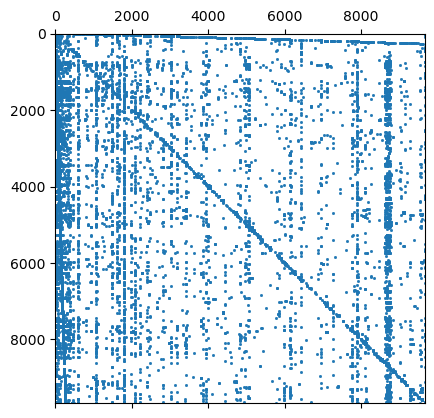

In [9]:
###########################
# California graph
#   http://vlado.fmf.uni-lj.si/pub/networks/data/mix/mixed.htm
#   This graph was constructed by expanding a 200-page response set 
#   to a search engine query 'California'.
###########################

network = np.loadtxt('datasets/california.dat')
row = network[:,0]-1
col = network[:,1]-1
n = int(np.max(network))+1 # nb of vertices
ne = len(row)
print('nb of nodes=',n)
print('nb of edges=',ne)

# Create Adjacency matrix W
data = np.ones([ne])
W = scipy.sparse.csr_matrix((data, (row, col)), shape=(n, n))
Wref = W
print(W.shape)

# Plot adjacency matrix
plt.figure(4)
plt.spy(W,precision=0.01, markersize=1)
plt.show()

In [10]:
# Solve eigenproblem

# vector of 1's
e = np.ones([n,1])/n 
one = np.ones([n,1])

# Dumpling vector
D = np.array(W.sum(axis=1),dtype='float32').squeeze()
a_idx = np.zeros([n],dtype='int32')
a_idx[np.where(D<1./2)] = 1
a = (1.0* a_idx)[:,None]

# Compute P = W D^{-1}
invD = 1./(D+1e-10)
invD[a_idx==1] = 0
invD = np.diag(invD)
W = Wref.todense()
P = invD.dot(W).T

# EVD
alpha = 0.85
start = time.time()
Phat = alpha* P +  alpha* e.dot(a.T) + (1.0-alpha)* e.dot(one.T)
Phat = scipy.sparse.csr_matrix(Phat)
lamb, U = scipy.sparse.linalg.eigs(Phat, k=1, which='LM') 
x_pagerank = np.abs(U[:,0])/ np.sum(np.abs(U[:,0]))

# Computational time
print('Computational time for PageRank solution with EIGEN Method (sec):',time.time() - start)

Computational time for PageRank solution with EIGEN Method (sec): 10.947153806686401


In [11]:
# Power Method

# Initialization
x = e
diffx = 1e10
k = 0

# Iterative scheme
start = time.time()
alpha = 0.85
while (k<1000) & (diffx>1e-6):
    
    # Update iteration
    k += 1

    # Update x
    xold = x
    x = alpha* P.dot(x) + e.dot( alpha* a.T.dot(x) + (1.0-alpha) )
    
    # Stopping condition
    diffx = np.linalg.norm(x-xold,1)
    
x_pagerank_PM = np.array(x).squeeze(axis=1)

# Computational time
print('Computational time for PageRank solution with POWER Method (sec):',time.time() - start)

Computational time for PageRank solution with POWER Method (sec): 1.5665569305419922
